In [77]:
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime
import xarray as xr
import rioxarray

In [36]:
merged_coords_1 = pd.read_csv("../data/merged_coords_batch1.csv")
merged_coords_2 = pd.read_csv("../data/merged_coords_batch2.csv")
merged_coords = pd.concat([merged_coords_1, merged_coords_2], ignore_index=True)

In [112]:
name = merged_coords["name"][0]
lat = merged_coords["Lat"][0]
lon = merged_coords["Lon"][0]
base_dir = "/home/hamid/mnt/nas/Hamid/GLASS/EC_SITES/"
years = np.arange(2002, 2022)
fnames = []
dates = []

for year in years:
    dir_path = os.path.join(base_dir, name, str(year))
    tif_files = glob.glob(dir_path + "/*.tif")
    # add and if clause to check if number of files are exactly 46
    for file in tif_files:
        fnames.append(file)
        date_part = file.split("/")[-1].split(".")[2][1:]
        dates.append(datetime.strptime(date_part, "%Y%j").date())

In [111]:
data_arrays = []

for fname, date in zip(fnames, dates):
    da = rioxarray.open_rasterio(fname)
    da = da.squeeze().drop("band")  # Remove the band dimension if it exists
    da = da.expand_dims(time=[date])  # Add time dimension
    data_arrays.append(da)
combined_da = xr.concat(data_arrays, dim="time")
combined_da = combined_da.assign_coords(
    lon=("x", np.linspace(lon - 0.5, lon + 0.5, combined_da.shape[-1])),
    lat=("y", np.linspace(lat - 0.5, lat + 0.5, combined_da.shape[-2])),
)
combined_da.attrs["site_name"] = name
combined_da.attrs["latitude"] = lat
combined_da.attrs["longitude"] = lon
ds = combined_da.to_dataset(name="glass_lai")

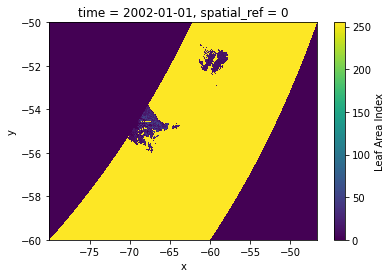